In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [23]:
from numpy.typing import NDArray
from typing import List, Tuple

In [3]:
img = cv2.imread('input/input.png')

In [4]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply( cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) )

In [5]:
def structuralFiltering(img : NDArray) -> NDArray:
    # r1 = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
    # R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
    # r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 1)
    # R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 1)
    # r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23)), iterations = 1)
    # R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23)), iterations = 1)
    # f4 = cv2.subtract(R3, green)
    # f5 = clahe.apply(f4)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    return tophat

In [26]:
def histogram_plot(img : NDArray, title : str = None, dpi : int = 90):
    hist, bins = np.histogram( img.ravel(), bins=256, range=[0,256])
    plt.figure(figsize=(16,9), dpi=dpi)
    plt.plot(bins[:-1], hist)
    if title:
        plt.title(title)
    plt.xlabel('Intensity')
    plt.ylabel('Count')

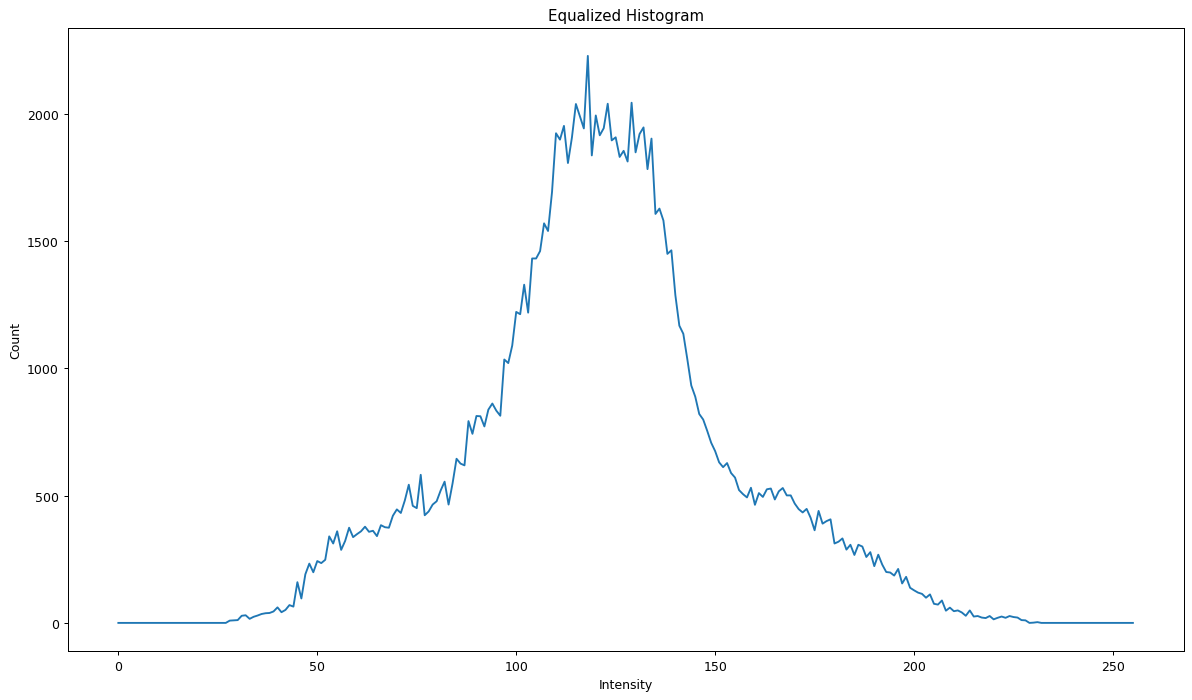

In [27]:
histogram_plot(equalized, "Equalized Histogram")

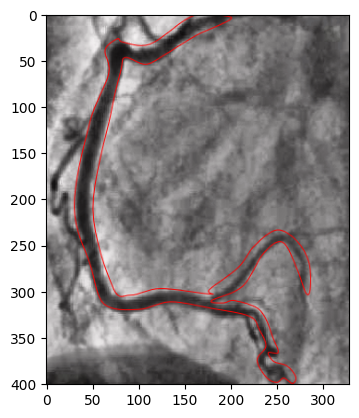

In [8]:
regions_img = cv2.cvtColor(
    cv2.imread('input/regions.png'),
    cv2.COLOR_RGB2BGR
)
_ = plt.imshow(regions_img)

In [9]:
def show_channels(img : NDArray, suptitle : str = None, subtitles : list = None, dpi : int = 90):
    fig = plt.figure(figsize=(16,9), dpi=dpi)
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        if subtitles:
            plt.gca().set_title(subtitles[i])
        plt.imshow(img[:,:,i], 'gray')
    if suptitle is not None:
        fig.suptitle(suptitle, size=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

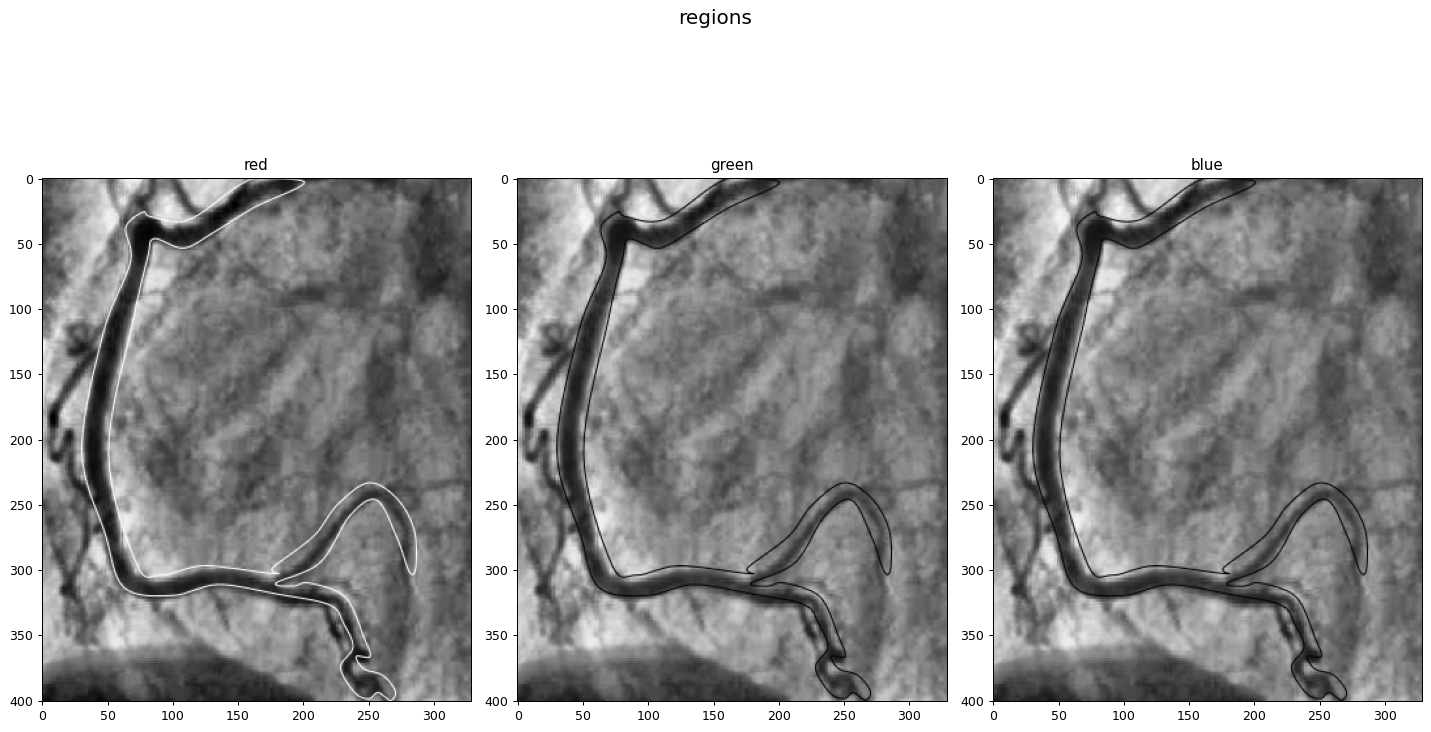

In [10]:
show_channels(regions_img, suptitle="regions", subtitles=['red','green','blue'])

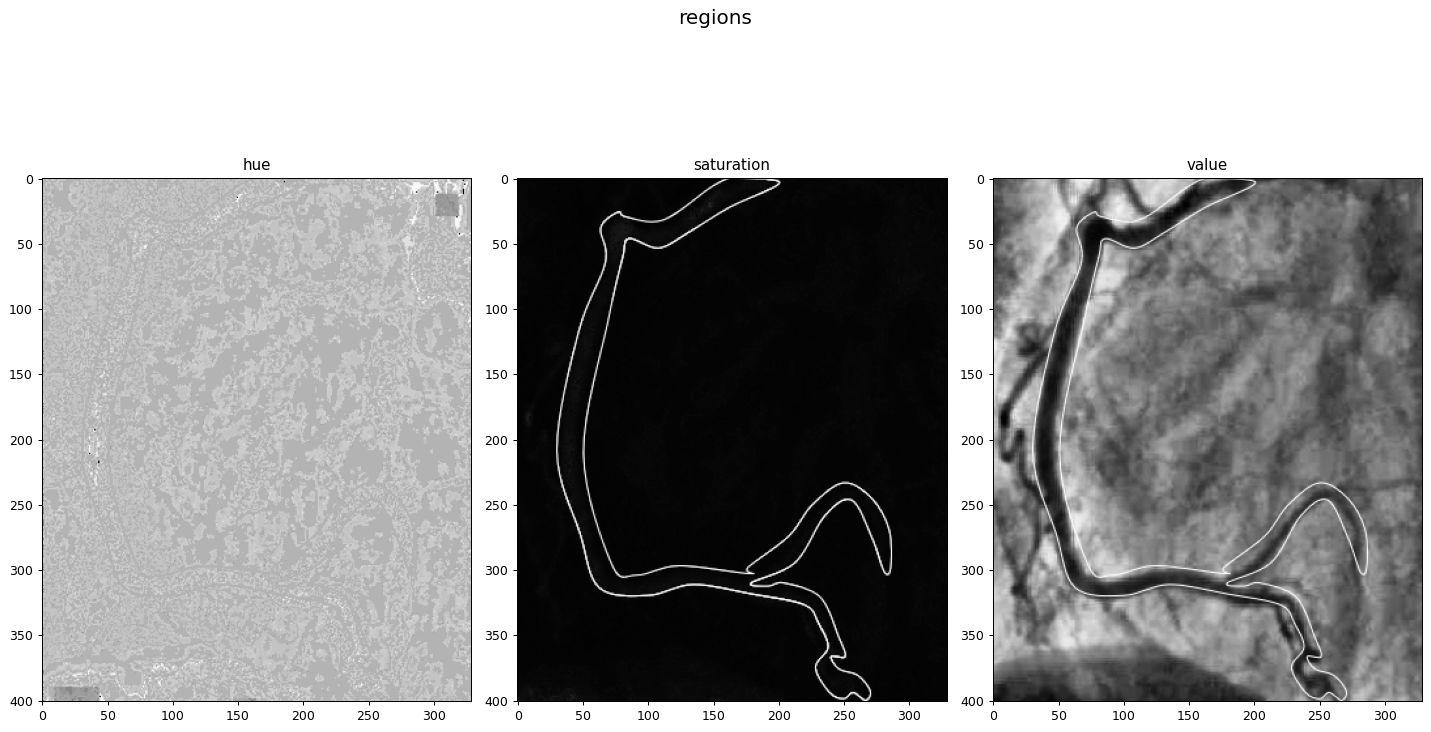

In [12]:
hsv = cv2.cvtColor(regions_img, cv2.COLOR_BGR2HSV)
show_channels(hsv, 'regions', subtitles=['hue', 'saturation', 'value'])

# Find the region boundary contour

In [15]:
contours, _ = cv2.findContours(hsv.copy()[:,:,1], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros(img.shape, np.uint8)
contour_img = cv2.drawContours(mask, contours, -1, (255), 1)

In [20]:
contour_img.all()

False